In [1]:
import importlib
from pathlib import Path

import numpy as np
import pandas as pd

import config
import module
from tests import test

for p in [config, module,test]:
    try:
        importlib.reload(p)  # reload module
    except NameError:
        pass

# Load DF

In [2]:
# load DFs
df_att = pd.read_excel(config.path_attendance_data)
df_sess = pd.read_excel(config.path_session_data)
df_trainer = pd.read_excel(config.path_trainer_data, sheet_name=config.month)
df_noncoco = pd.read_excel(config.path_noncoco)
df_coco_member = pd.read_excel(config.path_coco_member)
df_erwin_member = pd.read_excel(config.path_erwin_member)

# Clean and Merge DF

In [3]:
# add data source column to df_sess and df noncoco
# drop index column
# sort column alphabetically
df_sess = (
    df_sess.assign(data_source="coco")
    .drop(columns="index", errors="ignore")
    .loc[:, lambda df_: sorted(df_.columns)]
)
df_noncoco = (
    df_noncoco.assign(data_source="noncoco")
    .drop(columns="index", errors="ignore")
    .loc[:, lambda df_: sorted(df_.columns)]
)

# merge df session and df noncoco
df_sess_full = pd.concat([df_sess, df_noncoco], axis=0)
df_sess_full = (
    df_sess_full.reset_index(drop=True)
    .assign(index=lambda df_: df_.index + 1)
    .assign(
        class_duration=lambda df_: pd.to_numeric(df_["class_duration"], errors="raise"),
        class_grouping=lambda df_: df_["class_type_grouped"].map(module.class_grouping),
    )
)
df_sess_full.shape

(5686, 20)

## Test

In [4]:
test.test_noncoco_online_class_is_online_location(df_noncoco)
test.test_coco_and_noncoco_cols_same(df_sess, df_noncoco)
test.test_class_exist_in_module_class_grouping(df_sess_full)
test.test_teacher_center_area_position_not_null(df_sess_full)
test.test_no_trainer_is_duplicated(df_trainer)
test.test_all_coco_student_centers_are_mapped_in_center_order(df_coco_member)
test.test_all_erwin_student_centers_are_mapped_in_center_order(df_erwin_member)

# Sheet 3: Class Session & util

In [5]:
class_session = (
    df_sess_full
    # ! exclude GOC
    .loc[df_sess_full["class_mode"] != "GOC"]
    .groupby(["class_grouping", "class_mode", "class_type_grouped"])
    .agg(
        total_scheduled_session=("index", "nunique"),
        # count how many rows have status "Given"
        total_delivered_session=("class_status", lambda c: (c == "Given").sum()),
        # use sum first because to obtain avg, have to divide sum by num of classes
        total_attendance=("class_attendance", "sum"),
    )
    .assign(
        max_attendance=lambda df_: df_.index.get_level_values(2).map(
            module.class_target
        ),
        avg_attendance=lambda df_: (df_["total_attendance"]
            .div(df_["total_delivered_session"])
            .round(1)
            .replace(0.0, np.nan)
        ),
        avg_per_max_attendance=lambda df_: (df_["avg_attendance"]
            .div(df_["max_attendance"])
            .round(2)
        ),
        percentage_delivered=lambda df_: (df_["total_delivered_session"]
            .div(df_["total_scheduled_session"])
            .astype(float)
            .round(2)
        ),
    )
    # sort index to place "Other" below
    .sort_index(level=0, ascending=False)
    .rename(columns=lambda c: c.replace("_", " ").title())
    .rename_axis(["", "Class Mode", "Class Type Grouped"])
    .loc[
        :,
        [
            "Total Scheduled Session",
            "Total Delivered Session",
            "Percentage Delivered",
            "Max Attendance",
            "Avg Attendance",
            "Avg Per Max Attendance",
        ],
    ]
)

class_session

Total Scheduled Session  \
         Class Mode Class Type Grouped                                   
VIP      Online     Online VPG                                     129   
                    Online One-on-one                              329   
         Offline    VPG                                             69   
                    One-on-one                                     460   
Standard Online     Online Social Club                             288   
                    Online First Lesson                             78   
                    Online Encounter                                 1   
                    Online Complementary                           351   
                    Online Community                                35   
                    Online Advising Session                        157   
         Offline    Social Club                                    495   
                    Member's Party                                  16   
                    First Lesson                                   141   
                    Complementary                                  385   
                    Community                                       80   
                    Chat Hour                                      237   
                    Advising Session                                 7   
Other    Online     Online Proskill                                  8   
                    Online IELTS First Lesson                        7   
                    Online IELTS                                     7   
         Offline    Proskill First Lesson                            6   
                    Proskill                                        10   
                    Other                                          282   
                    Mock Test                                       21   
                    IELTS First Lesson                               7   
                    IELTS                                           31   

                                               Total Delivered Session  \
         Class Mode Class Type Grouped                                   
VIP      Online     Online VPG                                     112   
                    Online One-on-one                              220   
         Offline    VPG                                             59   
                    One-on-one                                     356   
Standard Online     Online Social Club                             286   
                    Online First Lesson                             78   
                    Online Encounter                                 0   
                    Online Complementary                           347   
                    Online Community                                30   
                    Online Advising Session                        143   
         Offline    Social Club                                    443   
                    Member's Party                                  16   
                    First Lesson                                   137   
                    Complementary                                  321   
                    Community                                       71   
                    Chat Hour                                      230   
                    Advising Session                                 7   
Other    Online     Online Proskill                                  8   
                    Online IELTS First Lesson                        7   
                    Online IELTS                                     7   
         Offline    Proskill First Lesson                            6   
                    Proskill                                        10   
                    Other                                          272   
                    Mock Test                                       21   
                    IELTS First Lesson            

## Test

In [6]:
test.test_all_classes_are_included(df_sess_full, class_session)

# Sheet 4: ET Utilization

In [7]:
et_excluded= []

et_util = (
    df_sess_full
    # merge with df trainer to get working days etc
    .merge(df_trainer, how="left", on="teacher")
    # ! exclude et if less than 1 month
    .loc[lambda df_: ~(df_['teacher'].isin(et_excluded))]
    # to calculate class duration for delivered only,
    # create a temp column
    # if given, leave, if not given, 0
    .assign(
        class_duration_delivered=lambda df_: np.where(
            df_["class_status"] == "Given", df_["class_duration"], 0
        )
    )
    .groupby(["teacher_position_y", "teacher_area_x", "teacher"])
    .agg(
        working_days=("teacher_working_days", "mean"),
        total_scheduled_hours=("class_duration", "sum"),
        total_delivered_hours=("class_duration_delivered", "sum"),
    )
    # filter only for ET and coach
    .loc[
        lambda df_: df_.index.get_level_values("teacher_position_y").isin(
            ["ET", "Coach"]
        )
    ]
    .assign(
        working_days=lambda df_: df_["working_days"].astype("Int64"),
        total_scheduled_hours=lambda df_: df_["total_scheduled_hours"].astype(int),
        total_delivered_hours=lambda df_: df_["total_delivered_hours"].astype(int),
        scheduled_hours_per_day=lambda df_: (
            df_["total_scheduled_hours"].div(df_["working_days"]).round(1)
        ),
        delivered_hours_per_day=lambda df_: (
            df_["total_delivered_hours"].div(df_["working_days"]).round(1)
        ),
        max_class_hours=lambda df_: module.create_max_hour_per_trainer(df_),
        scheduled_utilization=lambda df_: df_["scheduled_hours_per_day"]
        .div(df_["max_class_hours"])
        .round(2),
        delivered_utilization=lambda df_: df_["delivered_hours_per_day"]
        .div(df_["max_class_hours"])
        .round(2),
    )
    .rename(columns=lambda c: c.replace("_", " ").title())
    .rename_axis(["Teacher Position", "Teacher Area", "Teacher"])
)
print(et_util.shape)
et_util.head()

(37, 8)


Working Days  \
Teacher Position Teacher Area Teacher                                    
Coach            BDG          Mustikawati Eka                       20   
                 JKT 1        Hamsah Handayani Ratnasari            16   
                              Mordechai Kaleb Arthur                21   
                              Oktavia Cindy                         19   
                              Rifani Aurora Nurhidayah              17   

                                                          Total Scheduled Hours  \
Teacher Position Teacher Area Teacher                                             
Coach            BDG          Mustikawati Eka                               114   
                 JKT 1        Hamsah Handayani Ratnasari                    106   
                              Mordechai Kaleb Arthur                        109   
                              Oktavia Cindy                                  97   
                              Rifani Aurora Nurhidayah                      100   

                                                          Total Delivered Hours  \
Teacher Position Teacher Area Teacher                                             
Coach            BDG          Mustikawati Eka                                99   
                 JKT 1        Hamsah Handayani Ratnasari                     93   
                              Mordechai Kaleb Arthur                         91   
                              Oktavia Cindy                                  72   
                              Rifani Aurora Nurhidayah                       87   

                                                          Scheduled Hours Per Day  \
Teacher Position Teacher Area Teacher                                               
Coach            BDG          Mustikawati Eka                                 5.7   
                 JKT 1        Hamsah Handayani Ratnasari                      6.6   
                              Mordechai Kaleb Arthur                          5.2   
                              Oktavia Cindy                                   5.1   
                              Rifani Aurora Nurhidayah                        5.9   

                                                          Delivered Hours Per Day  \
Teacher Position Teacher Area Teacher                                               
Coach            BDG          Mustikawati Eka                                 5.0   
                 JKT 1        Hamsah Handayani Ratnasari                      5.8   
                              Mordechai Kaleb Arthur                          4.3   
                              Oktavia Cindy                                   3.8   
                              Rifani Aurora Nurhidayah                        5.1   

                                                          Max Class Hours  \
Teacher Position Teacher Area Teacher                                       
Coach            BDG          Mustikawati Eka                         5.0   
                 JKT 1        Hamsah Handayani Ratnasari              5.0   
                              Mordechai Kaleb Arthur                  5.0   
                              Oktavia Cindy                           5.0   
                              Rifani Aurora Nurhidayah                5.0   

                                                          Scheduled Utilization  \
Teacher Position Teacher Area Teacher                                             
Coach            BDG          Mustikawati Eka                              1.14   
                 JKT 1        Hamsah Handayani Ratnasari                   1.32   
                              Mordechai Kaleb Arthur                       1.04   
                              Oktavia Cindy                                1.02   
                              Rifani Aurora Nurhidayah                     1.18   

                                                          Del

# Sheet 5: Ooolab

In [8]:
ooolab= (df_sess_full
    .loc[df_sess_full['teacher_center'] == 'Ooolab']
    .groupby(['class_service', 'class_mode', 'class_type_grouped', 'class_type'])
    .size()
    .to_frame()
    .rename(columns= {0: 'count'})
    .rename(columns= lambda c: c.replace('_', ' ').title())
    .rename_axis(['Class Service', 'Class Mode', 'Class Type Grouped', 'Class Type'])
)
ooolab

Count
Class Service Class Mode Class Type Grouped   Class Type                  
Deluxe & Go   Online     Online Complementary Online Complementary      95
                         Online Social Club   Online Social Club        61
VIP           Online     Online VPG           Online Complementary       2
                                              Online English Corner     65

# Sheet 6: Community

## Filter for Community Classes

In [9]:
df_comm = (
    df_sess_full
    # filter for community
    .loc[df_sess_full["class_type_grouped"].isin(["Online Community", "Community"])]
    .assign(
        # create com name
        community_name=lambda df_: module.create_com_class(
            df_["class_description"]
        ),
        # create com class type
        community_class_type=lambda df_: module.create_com_class_type(
            df_["class_description"]
        ),
    )
)

## Community Report 1

In [10]:
df_comm_report = (
    df_comm
    .groupby(["community_name", "community_class_type", "class_mode"])
    .agg(
        total_scheduled_session=("community_class_type", "count"),
        total_delivered_session=("class_status", lambda i: (i == "Given").sum()),
        total_attendance=("class_attendance", "sum"),
        avg_attendance=("class_attendance", "mean"),
    )
    .assign(
        avg_attendance=lambda df_: df_["avg_attendance"].round(1),
        percentage_delivered=lambda df_: df_["total_delivered_session"]
        .div(df_["total_scheduled_session"])
        .round(2),
    )[
        [
            "total_scheduled_session",
            "total_delivered_session",
            "percentage_delivered",
            "total_attendance",
            "avg_attendance",
        ]
    ]
    .rename(columns=lambda c: c.replace("_", " ").title())
    .rename_axis(["Community", "Class Type", "Class Mode"])
)
df_comm_report

Total Scheduled Session  \
Community Class Type Class Mode                            
CRE-8     Meet Up    Offline                           9   
                     Online                            3   
          Other      Offline                           1   
          Workshop   Offline                           7   
                     Online                            3   
Leap      Meet Up    Offline                           9   
                     Online                            4   
          Other      Offline                           1   
          Showcase   Offline                           1   
          Workshop   Offline                           8   
                     Online                            4   
Re-Charge Meet Up    Offline                           7   
                     Online                            4   
          Workshop   Offline                          10   
                     Online                            4   
Syndicate Meet Up    Offline                           9   
                     Online                            4   
          Other      Offline                           1   
          Showcase   Offline                           1   
          Workshop   Offline                           8   
                     Online                            4   
UNNAMED   Other      Offline                           8   
                     Online                            5   

                                 Total Delivered Session  \
Community Class Type Class Mode                            
CRE-8     Meet Up    Offline                           9   
                     Online                            3   
          Other      Offline                           1   
          Workshop   Offline                           7   
                     Online                            3   
Leap      Meet Up    Offline                           9   
                     Online                            4   
          Other      Offline                           1   
          Showcase   Offline                           1   
          Workshop   Offline                           8   
                     Online                            4   
Re-Charge Meet Up    Offline                           7   
                     Online                            4   
          Workshop   Offline                           9   
                     Online                            4   
Syndicate Meet Up    Offline                           9   
                     Online                            4   
          Other      Offline                           1   
          Showcase   Offline                           1   
          Workshop   Offline                           8   
                     Online                            4   
UNNAMED   Other      Offline                           0   
                     Online                            0   

                                 Percentage Delivered  Total Attendance  \
Community Class Type Class Mode                                           
CRE-8     Meet Up    Offline                      1.0              58.0   
                     Online                       1.0              38.0   
          Other      Offline                      1.0               1.0   
          Workshop   Offline                      1.0              50.0   
                     Online                       1.0              32.0   
Leap      Meet Up    Offline                      1.0              47.0   
                     Online                       1.0              65.0   
          Other      Offline                      1.0               2.0   
          Showcase   Offline                      1.0               2.0   
          Workshop   Offline                      1.0              56.0   
                     Online                       1.0              44.0   
Re-Charge Meet Up    Offline                      1.0   

## Community Report 2

Get the attendance for community classes only.

In [11]:
df_att_comm = (
    df_att
    # create community class type
    .assign(
        community_class_type=lambda df_: module.create_comm_class_for_att(df_)
    )
    # filter for community
    .loc[lambda df_: df_["community_class_type"] != "NONE"]
    # filter for attendance
    .loc[lambda df_: df_["student_attendance"] == "Attend"]
)

Group.

In [12]:
def catchstate(df, var_name: str) -> 'pd.DataFrame':
    """
    Helper function that captures intermediate Dataframes mid-chain.
    In the global namespace, make a new variable called var_name and set it to dataframe
    """
    globals()[var_name] = df
    return df

df_comm_report_2 = (
    df_att_comm
    .groupby("student_code")
    .agg(num_class_attended=("student_code", "size"))
    .reset_index()
    .groupby("num_class_attended")
    .agg(num_members_who_join_x_class=("num_class_attended", "size"))
    .pipe(catchstate, "temp")
    .reindex(range(1, temp.index.max()+1))
    .fillna(0)
    .astype(int)
    .reset_index()
    .rename(columns=lambda c: c.replace("_", " ").title())
)
df_comm_report_2

,Num Class Attended,Num Members Who Join X Class
0,1,265
1,2,122
2,3,45
3,4,18
4,5,8
5,6,8
6,7,2
7,8,2
8,9,0
9,10,0


## Test

In [13]:
test.test_all_com_classes_are_included(df_sess_full, df_comm_report)
test.test_total_att_1_eq_total_att_2(df_comm_report, df_comm_report_2)

# Sheet 7: Member Cohort

## Load DFs

In [14]:
# create a date range from jan 2023 to current month
date_ranges = pd.date_range(
    start="2023-01-01",
    end=(pd.to_datetime(config.month, format="%Y-%m") + pd.offsets.MonthEnd(0)),
    freq="m",
    inclusive="both",
)

# create a date range from jan 2023 to current month in a readable format
month_ranges = [i.strftime("%Y-%m").lower() for i in date_ranges]

# list of all att files
att_files = [
    f"{config.path_attendance_data_parent}/2023/{i}/data-attendance-{i}.xlsx"
    for i in month_ranges
]
att_files = att_files + [
    f"{config.path_attendance_data_parent}/2024/{i}/data-attendance-{i}.xlsx"
    for i in month_ranges
]

# get all att files and concat
dfs = []
for file in att_files:
    try:
        df = pd.read_excel(
            file, usecols=["student_code", "class_date", "student_attendance"]
        )
        dfs.append(df)
    except FileNotFoundError:
        pass
    
df_att_all_mo = pd.concat(dfs, ignore_index=True)
print(len(date_ranges), len(dfs))

13 13


## Create Cohort

In [15]:
cohort_start_date = (
    pd.to_datetime(config.month, format="%Y-%m") 
    - pd.Timedelta(days=330)
    - pd.offsets.MonthBegin(1) # make this the beginning of the month
)
cohort_end_date = (
    pd.to_datetime(config.month, format="%Y-%m") 
    + pd.offsets.MonthEnd(0)  # make this the end of the month
)
print(
    f"cohort start :{cohort_start_date: '%d %b %Y'}, cohort end :{cohort_end_date: '%d %b %Y'}"
)

cohort start : '01 Feb 2023', cohort end : '31 Jan 2024'


In [16]:
# the date on which the member join
df_member_clean = (
    df_coco_member.rename(columns={"start_date": "date"}).assign(is_first=True)
    # loc date between cohort start and end
    .loc[
        lambda df_: (df_["date"] >= cohort_start_date)
        & (df_["date"] <= cohort_end_date),
        ["student_code", "date", "is_first"],
    ]
)

# attendance of all member
df_att_all_mo_clean = (
    df_att_all_mo.loc[lambda df_: df_["student_attendance"] == "Attend"]  # only attend
    .drop(columns=["student_attendance"])
    .rename(columns={"class_date": "date"})
    # loc attendance between cohort start and end
    .loc[
        lambda df_: (df_["date"] >= cohort_start_date)
        & (df_["date"] <= cohort_end_date)
    ]
    # only include members who are in df_member_clean
    # else, old members who started before that will be in the data
    .loc[lambda df_: df_["student_code"].isin(
        df_member_clean["student_code"].unique()
    )]
)

# concat att and member
df_cohort_raw = (
    pd.concat([df_member_clean, df_att_all_mo_clean])
    # drop the same date
    .sort_values(["is_first", "date"])
    .drop_duplicates(subset=["student_code", "date"], keep="first")
    .drop(columns=["is_first"])
    .assign(date=lambda df_: pd.to_datetime(df_["date"]))
    .rename(columns={
        "student_code": "customer_id", 
        "date": "transaction_date"
    })
)

# note: somehow, there are members who started lesson before contract start
# for now, no time to check
# last time checked, there are 125 members
# which is about 3 percent (negligible)
def get_members_study_before_contract_start():
    return (df_cohort_raw
        .fillna(False)
        .assign(is_first=lambda df_: df_["is_first"].astype(str))
        .groupby(["customer_id", "is_first"])
        ["transaction_date"].min()
        .to_frame()
        .reset_index()
        .pivot(index="customer_id", columns="is_first")
        .reset_index()
        .droplevel(0, axis="columns")
        .loc[
            lambda df_: df_["True"] > df_["False"]
        ]
    )

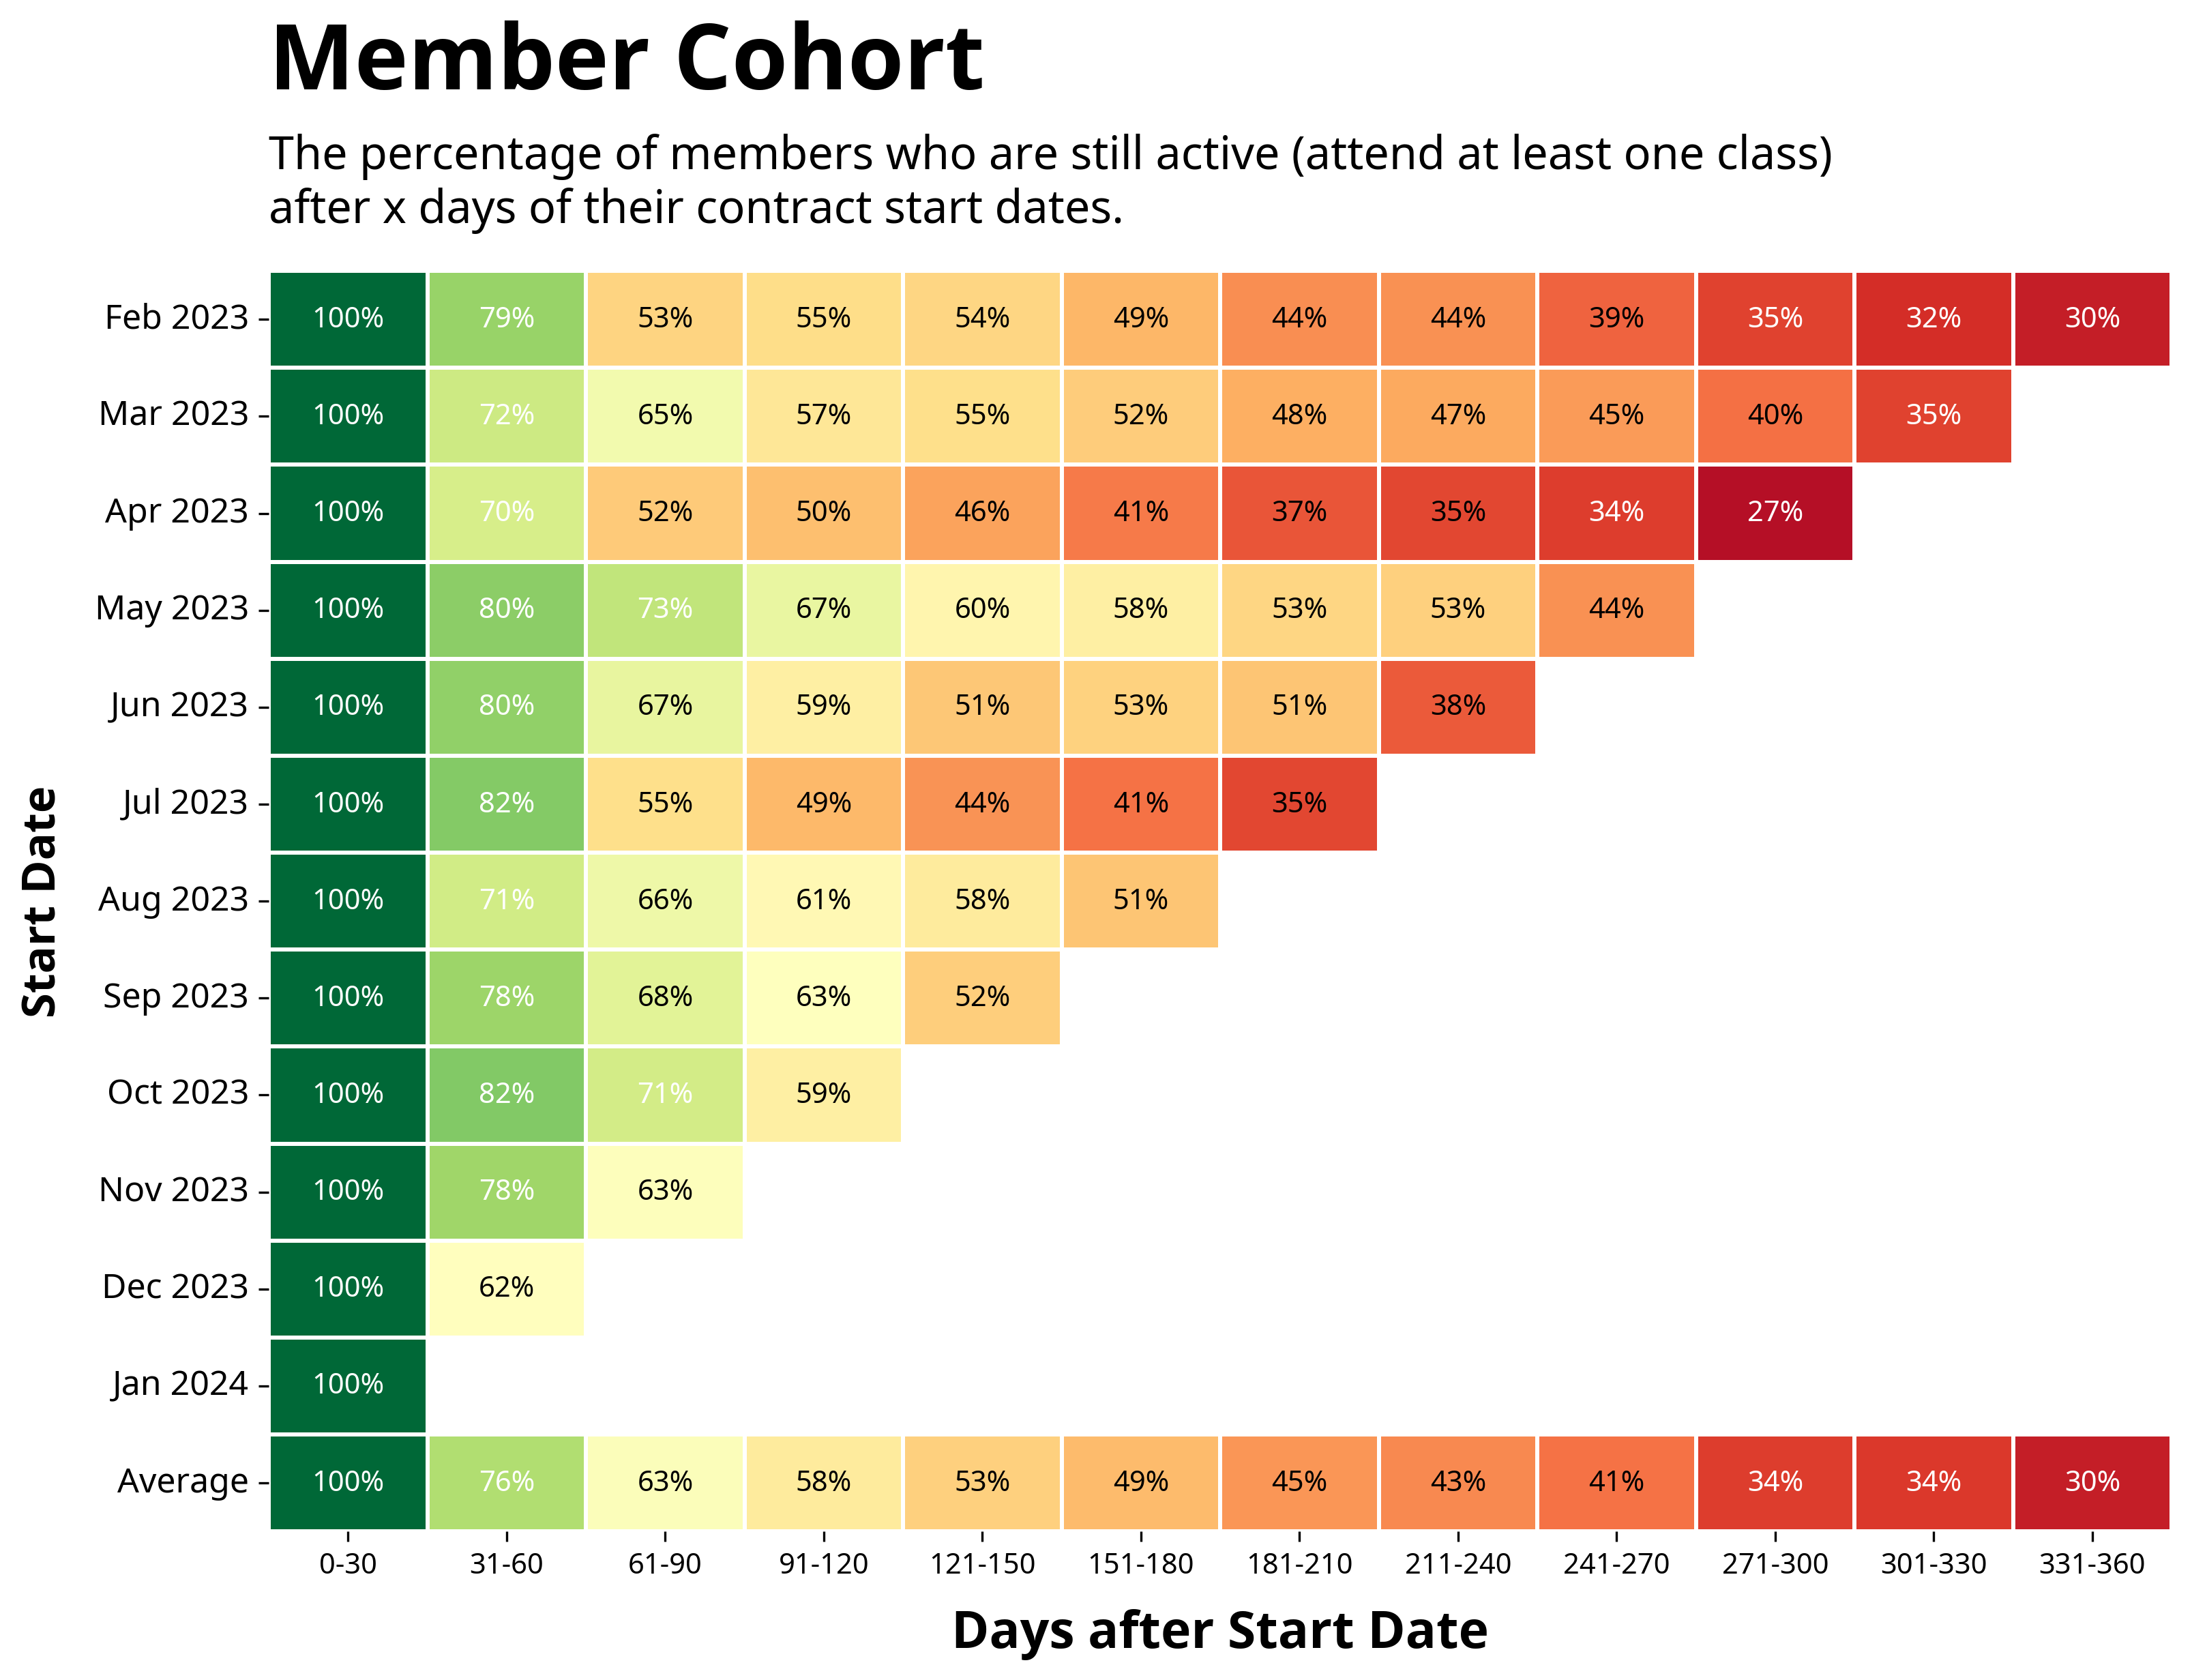

In [17]:
df_cohort = module.make_cohort(df_cohort_raw)
module.plot_cohort(df_cohort)

# Sheet 8: Center Population

## Population based on coco

In [18]:
# center_order = pd.CategoricalDtype(config.center_order, ordered=True)

In [19]:
# df_coco_pop = (df_coco_member
#     .assign(
#         # create activity for the current month
#         is_active = lambda df_: module.is_active(
#             df_, "start_date", "end_date", f"1 {config.month[3:]}"
#         ), 
#         # get student center and area
#         student_center = lambda df_: df_["student_center"].fillna("Not Specified").astype(center_order),
#         student_area = lambda df_: df_["student_area"].fillna("Not Specified"),
#         consultant = lambda df_: df_["consultant"].str.title(),
#     )
#     # filter only active student
#     .loc[lambda df_: df_["is_active"] == True]
#     # group 
#     .groupby(["student_area", "student_center", "student_membership"], observed=True)
#     .agg(
#         num_student=("student_code", "size")
#     )
#     # pivot
#     .reset_index()
#     .pivot(
#         index=["student_area", "student_center"],
#         columns="student_membership"
#     )
#     .sort_index(axis="rows", level=1)
#     .fillna(0)
#     .droplevel(0, axis="columns")
#     .rename_axis(["Area", "Center"], axis="rows")
#     .rename_axis([""], axis="columns")
# )
# df_coco_pop

In [20]:
# df_coco_pop_activity = (df_coco_member
#     .assign(
#         # create activity for the current month
#         is_active = lambda df_: module.is_active(
#             df_, "start_date", "end_date", f"1 {config.month[3:]}"
#         ), 
#         # get student center and area
#         student_center = lambda df_: df_["student_center"].fillna("Not Specified").astype(center_order),
#         student_area = lambda df_: df_["student_area"].fillna("Not Specified"),
#         is_class_active=lambda df_: np.where(
#             df_["student_code"].isin((df_att.loc[df_att["student_attendance"] == "Attend", "student_code"].unique())), 
#             "Class Active", "Class Inactive"
#         )
#     )
#     # filter only active student
#     .loc[lambda df_: df_["is_active"] == True]
#     # group 
#     .groupby(["student_area", "student_center", "is_class_active"], observed=True)
#     .agg(
#         num_student=("student_code", "size")
#     )
#     # pivot
#     .reset_index()
#     .pivot(
#         index=["student_area", "student_center"],
#         columns="is_class_active"
#     )
#     .sort_index(axis="rows", level=1)
#     .fillna(0)
#     .droplevel(0, axis="columns")
#     .rename_axis(["Area", "Center"], axis="rows")
#     .rename_axis([""], axis="columns")
# )
# df_coco_pop_activity

## Population based on erwin

In [21]:
# df_erwin_pop = (df_erwin_member
#     # filter only active student and coco student
#     .loc[
#         (df_erwin_member[f"active_{config.month[3:].replace(' ', '_')}"] == True) &
#         ~(df_erwin_member["core_product"].isna())
#     ]
#     # cast center as categorical for ordering
#     .assign(
#         center=lambda df_: df_["center"].astype(center_order)
#     )
#     .groupby(["area","center", "core_product"], observed=True)
#     .agg(
#         num_student=("center", "count")
#     )
#     # pivot
#     .reset_index()
#     .pivot(
#         index=["area", "center"],
#         columns="core_product"
#     )
#     .sort_index(axis="rows", level=1)
#     .fillna(0)
#     .droplevel(0, axis="columns")
#     .rename_axis(["Area", "Center"], axis="rows")
#     .rename_axis([""], axis="columns")
# )
# df_erwin_pop

In [22]:
# TODO: add assertion that no members area, center and membership is na or not specified in config.center_order.sum().sum()

# Data: Class Mapping

In [23]:
df_class_mapping = (
    df_sess_full
    # ! exclude GOC
    .loc[df_sess_full["class_mode"] != "GOC"]
    .assign(
        class_grouping=lambda df_: df_["class_type_grouped"].map(module.class_grouping)
    )
    .groupby(["class_grouping", "class_mode", "class_type_grouped", "class_type"])
    .agg(
        total_scheduled_session=("index", "nunique"),
        # count how many rows have status "Given"
        total_delivered_session=("class_status", lambda c: (c == "Given").sum()),
    )
    .rename_axis(["Class Grouping", "Class Mode", "Class Type Grouped", "Class Type"])
    .rename(columns=lambda c: c.replace("_", " ").title())
)

# Save DF

In [27]:
path = (
    Path.cwd() / f"output/Exp Management Report (Source) - {config.month_noncoco}.xlsx"
)
sheets = [
    "Class Session & Utilization",
    "ET Utilization",
    "Community Class",
    "Community Class 2",
    # 'Member Pop Erwin',
    # 'Member Pop Coco',
    # 'Member Pop Coco - Activity',
    "Ooolab",
    "Data - Session",
    "Data - Class Mapping",
    "Data - Community Session",
]
dfs = [
    class_session,
    et_util,
    df_comm_report,
    df_comm_report_2,
    # df_erwin_pop,
    # df_coco_pop,
    # df_coco_pop_activity,
    ooolab.reset_index(),
    df_sess_full,
    df_class_mapping,
    df_comm,
]

import os

if not os.path.exists(path):
    module.save_multiple_dfs(dfs, sheets, path)
    print("File saved.")
else:
    print("File already exist.")

File saved.


# Experiment

In [25]:
# teachers = [
#     "Algar Sinclair Alexander John",
#     "Gereau Jason Jarett",
#     "Jane Quinn Madeline",
#     "Handayani Khaerunisyah Risma",
#     "Johanson Brian",
#     "Jurado Michael John",
#     "Phillips Toby",
#     "Pratama Dimas Indra",
#     "Jones Jack William Isaac",
#     "Oktavia Cindy",
# ]
# for teacher in teachers:
#     result = (df_sess_full
#         .loc[df_sess_full['teacher'] == teacher, ['class_date', 'class_time', 'class_duration']]
#         .drop_duplicates()
#         .assign(class_hour= lambda df_: df_['class_time'].astype(str).str[:2])
#         .groupby('class_date')
#         .agg(
#             class_hour= ('class_hour', lambda x: ', '.join(x)),
#             total_hours= ('class_duration', 'sum')
#         )
#         .loc[lambda df_: df_['total_hours'] <= 6]
#         .reset_index()
#         .assign(
#                 class_date=lambda df_: df_["class_date"].dt.strftime("%d %b"), 
#                 total_hours=lambda df_: df_["total_hours"].astype(int)
#         )
#     )
#     print(teacher)
#     print(result.to_markdown(), end="\n\n")

In [26]:
# # this is the list of members in november or december
# df_member_nov_dec = (df_coco_member
#     .assign(
#         # create activity for the current month
#         is_member_nov = lambda df_: module.is_active(
#             df_, "start_date", "end_date", f"1 nov 2023"
#         ), 
#         is_member_dec = lambda df_: module.is_active(
#             df_, "start_date", "end_date", f"1 dec 2023"
#         ), 
#         # get student center and area
#         student_center = lambda df_: df_["student_center"].fillna("Not Specified").astype(center_order),
#         student_area = lambda df_: df_["student_area"].fillna("Not Specified"),
#     )
#     # get members who are active in nov or dec
#     .loc[lambda df_: 
#          (df_["is_member_nov"] == True) |
#          (df_["is_member_dec"] == True)
#     ]
# )

# df_member_active_nov_dec = (df_att_all_mo
#     .loc[lambda df_: 
#         (df_["class_date"] >= "2023-11-01") & (df_["class_date"] <= "2023-12-31")      
#     ]
#     .loc[
#         lambda df_: df_["student_attendance"] == "Attend"
#     ]
#     .loc[:, "student_code"]
#     .values
# )

# df_member_inactive_nov_dec = (df_member_nov_dec
#     .loc[lambda df_: 
#         ~(df_["student_code"].isin(df_member_active_nov_dec))
#     ]
# )

# filepath = "output/df_member_inactive_nov_dec.xlsx"
# df_member_inactive_nov_dec.to_excel(filepath, index=True)